<a href="https://colab.research.google.com/github/rusamentiaga/pytorch-test/blob/main/3_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters 
input_size = 784
hidden_size = 500
num_classes = 10
num_epochs = 5
batch_size = 100
learning_rate = 0.001

In [23]:
# MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='./data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

Using downloaded and verified file: ./data/MNIST/raw/train-images-idx3-ubyte.gz
Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw
Using downloaded and verified file: ./data/MNIST/raw/train-labels-idx1-ubyte.gz
Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:479: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [24]:
!ls data/MNIST/processed/

test.pt  training.pt


In [61]:
import matplotlib.pyplot as plt
from ipywidgets import interact

def ShowSample(i):
  sample=train_dataset[i]
  img = sample[0]
  label = sample[1]
  img = img.squeeze()
  img.shape
  plt.imshow(img)
  plt.gray()
  plt.title(f'Label: {label}')

interact(ShowSample, i=(0,len(train_dataset)-1));

interactive(children=(IntSlider(value=29999, description='i', max=59999), Output()), _dom_classes=('widget-int…

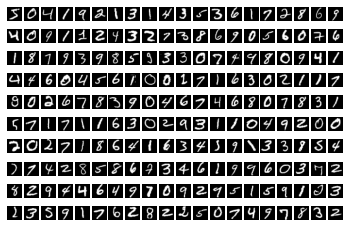

In [94]:
rows = 10
cols = 20

for i in range(rows):
  for j in range(cols):
    plt.subplot(rows,cols,1 + i*cols + j)
    sample=train_dataset[i*cols + j]
    img = sample[0]
    img = img.squeeze()
    plt.imshow(img)
    plt.gray()
    plt.axis('off')


torch.Size([100, 1, 28, 28])

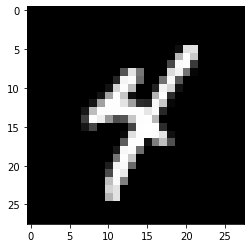

In [95]:
import matplotlib.pyplot as plt

for i, (images, labels) in enumerate(train_loader): 
  if i == 3:
    plt.figure()
    plt.imshow(images[0,0,:,:])
    break
images.shape

In [96]:


# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

model = NeuralNet(input_size, hidden_size, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))

Epoch [1/5], Step [100/600], Loss: 0.4335
Epoch [1/5], Step [200/600], Loss: 0.1857
Epoch [1/5], Step [300/600], Loss: 0.2063
Epoch [1/5], Step [400/600], Loss: 0.2440
Epoch [1/5], Step [500/600], Loss: 0.2081
Epoch [1/5], Step [600/600], Loss: 0.1461
Epoch [2/5], Step [100/600], Loss: 0.1465
Epoch [2/5], Step [200/600], Loss: 0.2065
Epoch [2/5], Step [300/600], Loss: 0.0659
Epoch [2/5], Step [400/600], Loss: 0.0548
Epoch [2/5], Step [500/600], Loss: 0.1006
Epoch [2/5], Step [600/600], Loss: 0.1703
Epoch [3/5], Step [100/600], Loss: 0.0513
Epoch [3/5], Step [200/600], Loss: 0.0799
Epoch [3/5], Step [300/600], Loss: 0.0260
Epoch [3/5], Step [400/600], Loss: 0.0893
Epoch [3/5], Step [500/600], Loss: 0.0386
Epoch [3/5], Step [600/600], Loss: 0.0572
Epoch [4/5], Step [100/600], Loss: 0.0344
Epoch [4/5], Step [200/600], Loss: 0.1361
Epoch [4/5], Step [300/600], Loss: 0.0495
Epoch [4/5], Step [400/600], Loss: 0.0510
Epoch [4/5], Step [500/600], Loss: 0.0497
Epoch [4/5], Step [600/600], Loss:

In [13]:
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7*7*32, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

model = ConvNet(num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

# Test the model
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))
    

Epoch [1/5], Step [100/600], Loss: 0.1427
Epoch [1/5], Step [200/600], Loss: 0.0750
Epoch [1/5], Step [300/600], Loss: 0.0699
Epoch [1/5], Step [400/600], Loss: 0.1148
Epoch [1/5], Step [500/600], Loss: 0.0645
Epoch [1/5], Step [600/600], Loss: 0.1749
Epoch [2/5], Step [100/600], Loss: 0.0117
Epoch [2/5], Step [200/600], Loss: 0.0344
Epoch [2/5], Step [300/600], Loss: 0.0134
Epoch [2/5], Step [400/600], Loss: 0.0494
Epoch [2/5], Step [500/600], Loss: 0.0379
Epoch [2/5], Step [600/600], Loss: 0.1414
Epoch [3/5], Step [100/600], Loss: 0.1201
Epoch [3/5], Step [200/600], Loss: 0.0426
Epoch [3/5], Step [300/600], Loss: 0.0664
Epoch [3/5], Step [400/600], Loss: 0.0194
Epoch [3/5], Step [500/600], Loss: 0.0283
Epoch [3/5], Step [600/600], Loss: 0.0327
Epoch [4/5], Step [100/600], Loss: 0.0460
Epoch [4/5], Step [200/600], Loss: 0.0803
Epoch [4/5], Step [300/600], Loss: 0.0051
Epoch [4/5], Step [400/600], Loss: 0.0250
Epoch [4/5], Step [500/600], Loss: 0.0528
Epoch [4/5], Step [600/600], Loss: